In [1]:
import os
import pandas as pd
import numpy as np
import ast
import torch
from torch.utils.data import Dataset
from transformers import AutoTokenizer, AutoModel, Trainer, TrainingArguments
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.metrics import precision_recall_fscore_support, accuracy_score, hamming_loss
import matplotlib.pyplot as plt
from google.colab import drive

In [2]:
# Mount Google Drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
# Define paths
PROJECT_DIR = "/content/drive/My Drive/NLP_Project"
DATA_DIR = os.path.join(PROJECT_DIR, "Dataset_EN_PT")
TRAIN_FILE = os.path.join(PROJECT_DIR, "train.csv")
TEST_FILE = os.path.join(PROJECT_DIR, "test.csv")
VAL_FILE = os.path.join(PROJECT_DIR, "val.csv")
RESULTS_DIR = os.path.join(PROJECT_DIR, "results")
os.makedirs(RESULTS_DIR, exist_ok=True)

In [4]:
# Load text data
def load_text(article_id):
    file_path = os.path.join(DATA_DIR, article_id)
    with open(file_path, "r", encoding="utf-8") as file:
        return file.read()

In [5]:
# Load datasets
train_df = pd.read_csv(TRAIN_FILE)
test_df = pd.read_csv(TEST_FILE)
val_df = pd.read_csv(VAL_FILE)

In [6]:
# MultiLabelBinarizer setup
mlb_main = MultiLabelBinarizer()
mlb_sub = MultiLabelBinarizer()

# Fit binarizers on training data
mlb_main.fit(train_df['main_role'].apply(lambda x: [x]))
mlb_sub.fit(train_df['fine_grained_roles'].apply(ast.literal_eval))

MultiLabelBinarizer()

In [7]:
# Preprocess data
def preprocess_data(df):
    df['fine_grained_roles'] = df['fine_grained_roles'].apply(ast.literal_eval)
    df['text'] = df['article_id'].apply(load_text)
    main_labels = mlb_main.transform(df['main_role'].apply(lambda x: [x]))
    sub_labels = mlb_sub.transform(df['fine_grained_roles'])
    return df, main_labels, sub_labels

# Prepare datasets
train_df, train_main_labels, train_sub_labels = preprocess_data(train_df)
val_df, val_main_labels, val_sub_labels = preprocess_data(val_df)
test_df, test_main_labels, test_sub_labels = preprocess_data(test_df)

In [8]:
tokenizer = AutoTokenizer.from_pretrained("xlm-roberta-base")

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/615 [00:00<?, ?B/s]

sentencepiece.bpe.model:   0%|          | 0.00/5.07M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/9.10M [00:00<?, ?B/s]

In [9]:
# Dataset class
class RoleClassificationDataset(Dataset):
    def __init__(self, df, main_labels, sub_labels, tokenizer, max_length=512):
        self.texts = df['text'].tolist()
        self.main_labels = main_labels
        self.sub_labels = sub_labels
        self.tokenizer = tokenizer
        self.max_length = max_length

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        inputs = self.tokenizer(
            self.texts[idx],
            padding="max_length",
            truncation=True,
            max_length=self.max_length,
            return_tensors="pt"
        )
        inputs = {key: val.squeeze(0) for key, val in inputs.items()}

        # Combine main and sub labels
        labels = np.concatenate((self.main_labels[idx], self.sub_labels[idx]))
        inputs['labels'] = torch.tensor(labels, dtype=torch.float)

        return inputs

# Create dataset instances
train_dataset = RoleClassificationDataset(train_df, train_main_labels, train_sub_labels, tokenizer)
val_dataset = RoleClassificationDataset(val_df, val_main_labels, val_sub_labels, tokenizer)
test_dataset = RoleClassificationDataset(test_df, test_main_labels, test_sub_labels, tokenizer)

In [10]:
# Model definition
class FocalLoss(torch.nn.Module):
    def __init__(self, alpha=1, gamma=2, reduction='mean'):
        super(FocalLoss, self).__init__()
        self.alpha = alpha
        self.gamma = gamma
        self.reduction = reduction

    def forward(self, inputs, targets):
        BCE_loss = torch.nn.functional.binary_cross_entropy_with_logits(inputs, targets, reduction='none')
        pt = torch.exp(-BCE_loss)
        focal_loss = self.alpha * (1 - pt) ** self.gamma * BCE_loss
        if self.reduction == 'mean':
            return focal_loss.mean()
        elif self.reduction == 'sum':
            return focal_loss.sum()
        else:
            return focal_loss

class AttentionLayer(torch.nn.Module):
    def __init__(self, hidden_dim):
        super(AttentionLayer, self).__init__()
        self.attention = torch.nn.Linear(hidden_dim, 1)

    def forward(self, x):
        attention_weights = torch.softmax(self.attention(x), dim=1)
        attended_output = torch.sum(x * attention_weights, dim=1)
        return attended_output

class RoleClassifier(torch.nn.Module):
    def __init__(self, base_model_name, num_main_labels, num_sub_labels):
        super(RoleClassifier, self).__init__()
        self.base_model = AutoModel.from_pretrained(base_model_name)
        self.attention = AttentionLayer(self.base_model.config.hidden_size)
        self.main_classifier = torch.nn.Linear(self.base_model.config.hidden_size, num_main_labels)
        self.sub_classifier = torch.nn.Linear(self.base_model.config.hidden_size, num_sub_labels)
        self.dropout = torch.nn.Dropout(0.3)
        self.criterion = FocalLoss(alpha=1, gamma=2)

    def forward(self, input_ids, attention_mask, labels=None):
        outputs = self.base_model(input_ids=input_ids, attention_mask=attention_mask)
        hidden_states = outputs.last_hidden_state
        attended_output = self.attention(hidden_states)
        pooled_output = self.dropout(attended_output)

        main_logits = self.main_classifier(pooled_output)
        sub_logits = self.sub_classifier(pooled_output)

        loss = None
        if labels is not None:
            num_main_classes = len(mlb_main.classes_)
            main_labels = labels[:, :num_main_classes]
            sub_labels = labels[:, num_main_classes:]

            main_loss = self.criterion(main_logits, main_labels)
            sub_loss = self.criterion(sub_logits, sub_labels)
            loss = main_loss + sub_loss

        return {"loss": loss, "main_logits": main_logits, "sub_logits": sub_logits}

model = RoleClassifier("xlm-roberta-base", len(mlb_main.classes_), len(mlb_sub.classes_))

model.safetensors:   0%|          | 0.00/1.12G [00:00<?, ?B/s]

In [15]:
training_args = TrainingArguments(
    output_dir=RESULTS_DIR,
    evaluation_strategy="epoch",
    save_strategy="epoch",
    save_total_limit=2,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=25,
    learning_rate=3e-5,
    weight_decay=0.01,
    logging_steps=25,
    eval_steps=100,
    logging_dir='./logs',
    report_to="tensorboard",
    lr_scheduler_type="linear",
    warmup_steps=20,
    gradient_accumulation_steps=2,
    fp16=True  # Enable mixed precision for faster training
)


/usr/local/lib/python3.11/dist-packages/transformers/training_args.py:1575: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


In [16]:
def compute_metrics(eval_pred):
    logits, labels = eval_pred

    # Split logits for main and sub roles
    main_logits, sub_logits = logits

    # Convert logits to probabilities
    main_preds = torch.sigmoid(torch.tensor(main_logits)).cpu().numpy()
    sub_preds = torch.sigmoid(torch.tensor(sub_logits)).cpu().numpy()

    # Convert labels to numpy
    labels = torch.tensor(labels).cpu().numpy()

    # Determine the number of classes
    num_main_classes = len(mlb_main.classes_)  # Number of main roles
    num_sub_classes = len(mlb_sub.classes_)    # Number of sub roles

    # Split labels into main and sub roles
    main_labels = labels[:, :num_main_classes]
    sub_labels = labels[:, num_main_classes:]

    # Binarize predictions
    main_preds_bin = (main_preds >= 0.5).astype(int)
    sub_preds_bin = (sub_preds >= 0.5).astype(int)

    # Compute evaluation metrics
    main_precision, main_recall, main_f1, _ = precision_recall_fscore_support(
        main_labels, main_preds_bin, average="macro", zero_division=0
    )
    main_accuracy = accuracy_score(main_labels, main_preds_bin)

    sub_precision, sub_recall, sub_f1, _ = precision_recall_fscore_support(
        sub_labels, sub_preds_bin, average="macro", zero_division=0
    )
    sub_accuracy = accuracy_score(sub_labels, sub_preds_bin)

    # Exact Match Ratio (EMR) calculations
    main_emr = (main_preds_bin == main_labels).all(axis=1).mean()
    sub_emr = (sub_preds_bin == sub_labels).all(axis=1).mean()

    return {
        "eval_main_accuracy": main_accuracy,
        "eval_main_f1": main_f1,
        "eval_sub_accuracy": sub_accuracy,
        "eval_sub_f1": sub_f1,
        "eval_main_emr": main_emr,
        "eval_sub_emr": sub_emr,
    }


In [17]:
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics,  # Added compute_metrics function
)

<ipython-input-17-c98a33c98368>:1: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


In [18]:
# Train the model
trainer.train()


Epoch,Training Loss,Validation Loss,Main Accuracy,Main F1,Sub Accuracy,Sub F1,Main Emr,Sub Emr
1,0.361600,0.266395,0.121429,0.566973,0.175000,0.064051,0.121429,0.175000
2,0.353500,0.244956,0.142857,0.567103,0.164286,0.059620,0.142857,0.164286
3,0.340900,0.260497,0.192857,0.583231,0.185714,0.070047,0.192857,0.185714
4,0.338600,0.287312,0.103571,0.531597,0.132143,0.056714,0.103571,0.132143
5,0.322600,0.270963,0.100000,0.541116,0.150000,0.064954,0.100000,0.150000
6,0.307500,0.258830,0.114286,0.545659,0.175000,0.067352,0.114286,0.175000
7,0.301900,0.257456,0.164286,0.560477,0.164286,0.068989,0.164286,0.164286
8,0.303900,0.255382,0.207143,0.535313,0.128571,0.068711,0.207143,0.128571
9,0.290400,0.266417,0.146429,0.534857,0.128571,0.067371,0.146429,0.128571
10,0.291000,0.263596,0.128571,0.550493,0.117857,0.071494,0.128571,0.117857


TrainOutput(global_step=1075, training_loss=0.2871026682299237, metrics={'train_runtime': 1995.2243, 'train_samples_per_second': 17.354, 'train_steps_per_second': 0.539, 'total_flos': 0.0, 'train_loss': 0.2871026682299237, 'epoch': 24.436781609195403})

In [19]:
# Save model, tokenizer, and configuration
trainer.save_model(RESULTS_DIR)
tokenizer.save_pretrained(RESULTS_DIR)
model.base_model.config.to_json_file(os.path.join(RESULTS_DIR, "config.json"))

In [20]:
# Evaluate the model
results = trainer.evaluate(test_dataset)
print("Test Results:", results)

Test Results: {'eval_main_accuracy': 0.33455882352941174, 'eval_main_f1': 0.6113702623906706, 'eval_sub_accuracy': 0.17279411764705882, 'eval_sub_f1': 0.08773476937331073, 'eval_main_emr': 0.33455882352941174, 'eval_sub_emr': 0.17279411764705882, 'eval_loss': 0.2283906638622284, 'eval_runtime': 3.2033, 'eval_samples_per_second': 84.911, 'eval_steps_per_second': 5.307, 'epoch': 24.436781609195403}


In [21]:
# Display Evaluation Metrics
print("\n--- Evaluation Metrics ---")

# Main role metrics
print(f"Main Role Accuracy: {results.get('eval_main_accuracy', 'N/A'):.4f}")
print(f"Main Role F1 Score: {results.get('eval_main_f1', 'N/A'):.4f}")
print(f"Main Role Exact Match Ratio (EMR): {results.get('eval_main_emr', 'N/A'):.4f}")
print()

# Sub role metrics
print(f"Sub Role Accuracy: {results.get('eval_sub_accuracy', 'N/A'):.4f}")
print(f"Sub Role F1 Score: {results.get('eval_sub_f1', 'N/A'):.4f}")
print(f"Sub Role Exact Match Ratio (EMR): {results.get('eval_sub_emr', 'N/A'):.4f}")
print()

# Overall loss
print(f"Evaluation Loss: {results.get('eval_loss', 'N/A'):.4f}")



--- Evaluation Metrics ---
Main Role Accuracy: 0.3346
Main Role F1 Score: 0.6114
Main Role Exact Match Ratio (EMR): 0.3346

Sub Role Accuracy: 0.1728
Sub Role F1 Score: 0.0877
Sub Role Exact Match Ratio (EMR): 0.1728

Evaluation Loss: 0.2284


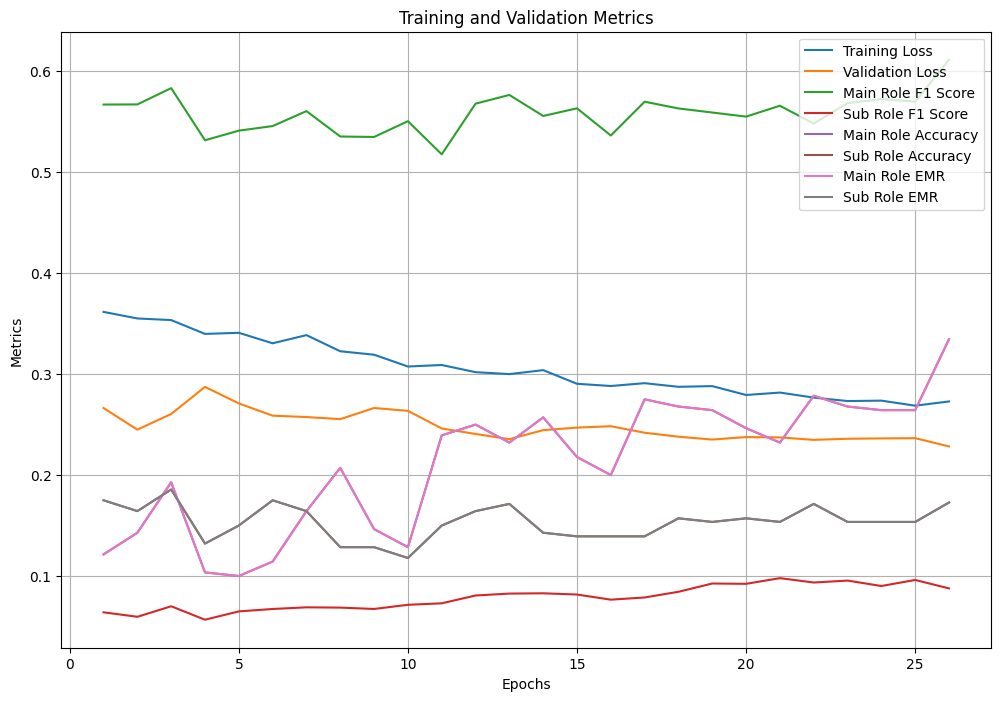

In [22]:
# Function to plot metrics
def plot_metrics(trainer):
    history = trainer.state.log_history

    # Extract metrics with safe checking to avoid missing keys
    train_loss = [entry['loss'] for entry in history if 'loss' in entry]
    eval_loss = [entry['eval_loss'] for entry in history if 'eval_loss' in entry]
    eval_main_f1 = [entry['eval_main_f1'] for entry in history if 'eval_main_f1' in entry]
    eval_sub_f1 = [entry['eval_sub_f1'] for entry in history if 'eval_sub_f1' in entry]
    eval_main_accuracy = [entry['eval_main_accuracy'] for entry in history if 'eval_main_accuracy' in entry]
    eval_sub_accuracy = [entry['eval_sub_accuracy'] for entry in history if 'eval_sub_accuracy' in entry]
    eval_main_emr = [entry['eval_main_emr'] for entry in history if 'eval_main_emr' in entry]
    eval_sub_emr = [entry['eval_sub_emr'] for entry in history if 'eval_sub_emr' in entry]

    # Find the minimum number of epochs across all metrics
    num_epochs = min(len(train_loss), len(eval_loss), len(eval_main_f1), len(eval_sub_f1),
                     len(eval_main_accuracy), len(eval_sub_accuracy), len(eval_main_emr), len(eval_sub_emr))

    # Handle cases where no sufficient data is available
    if num_epochs == 0:
        print("No sufficient data to plot metrics.")
        return

    epochs = list(range(1, num_epochs + 1))

    plt.figure(figsize=(12, 8))

    # Plot each metric with proper slicing
    plt.plot(epochs, train_loss[:num_epochs], label='Training Loss')
    plt.plot(epochs, eval_loss[:num_epochs], label='Validation Loss')
    plt.plot(epochs, eval_main_f1[:num_epochs], label='Main Role F1 Score')
    plt.plot(epochs, eval_sub_f1[:num_epochs], label='Sub Role F1 Score')
    plt.plot(epochs, eval_main_accuracy[:num_epochs], label='Main Role Accuracy')
    plt.plot(epochs, eval_sub_accuracy[:num_epochs], label='Sub Role Accuracy')
    plt.plot(epochs, eval_main_emr[:num_epochs], label='Main Role EMR')
    plt.plot(epochs, eval_sub_emr[:num_epochs], label='Sub Role EMR')

    plt.xlabel('Epochs')
    plt.ylabel('Metrics')
    plt.title('Training and Validation Metrics')
    plt.legend()
    plt.grid()
    plt.show()


plot_metrics(trainer)

In [23]:
# Sample test inferences

test_sample_1_idx = 65
test_sample_2_idx = 78

test_samples = [
    (test_df['article_id'].iloc[test_sample_1_idx], test_df['main_role'].iloc[test_sample_1_idx], test_df['fine_grained_roles'].iloc[test_sample_1_idx]),
    (test_df['article_id'].iloc[test_sample_2_idx], test_df['main_role'].iloc[test_sample_2_idx], test_df['fine_grained_roles'].iloc[test_sample_2_idx])
]


def infer_samples(samples):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    model.eval()
    for (article_id, main_role, sub_roles) in samples:
        input_text = f"Article ID: {article_id}, Main Role: {main_role}, Sub Roles: {sub_roles}"
        inputs = tokenizer(input_text, padding=True, truncation=True, return_tensors="pt").to(device)
        with torch.no_grad():
            outputs = model(**inputs)
            main_preds = torch.sigmoid(outputs['main_logits']).cpu().numpy()
            sub_preds = torch.sigmoid(outputs['sub_logits']).cpu().numpy()
            predicted_main_roles = mlb_main.inverse_transform(main_preds >= 0.5)
            predicted_sub_roles = mlb_sub.inverse_transform(sub_preds >= 0.5)
            print(f"Input: {input_text}")
            print(f"Predicted Main Role: {predicted_main_roles}")
            print(f"Predicted Sub Roles: {predicted_sub_roles}\n")

infer_samples(test_samples)

Input: Article ID: EN_CC_100136.txt, Main Role: Antagonist, Sub Roles: ['Deceiver']
Predicted Main Role: [('Antagonist',)]
Predicted Sub Roles: [()]

Input: Article ID: EN_CC_100035.txt, Main Role: Antagonist, Sub Roles: ['Conspirator']
Predicted Main Role: [('Antagonist',)]
Predicted Sub Roles: [()]



In [24]:
# Check the test data
print(test_df['article_id'].iloc[test_sample_1_idx])
print(test_df['article_id'].iloc[test_sample_2_idx])

EN_CC_100136.txt
EN_CC_100035.txt


In [25]:
# Check test samples
test_samples

[('EN_CC_100136.txt', 'Antagonist', ['Deceiver']),
 ('EN_CC_100035.txt', 'Antagonist', ['Conspirator'])]

In [34]:
import torch
from torch.utils.data import DataLoader
from sklearn.metrics import precision_recall_fscore_support, accuracy_score
import numpy as np
import pandas as pd

# Define a DataLoader for the test dataset
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False)

def evaluate_on_test_set(model, dataloader, mlb_main, mlb_sub, results_dir):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    model.eval()

    all_main_preds = []
    all_sub_preds = []
    all_main_labels = []
    all_sub_labels = []
    all_article_ids = []

    with torch.no_grad():
        for batch in dataloader:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)

            # Forward pass
            outputs = model(input_ids=input_ids, attention_mask=attention_mask)

            # Separate logits for main and sub roles
            main_logits = outputs['main_logits']
            sub_logits = outputs['sub_logits']

            # Convert logits to probabilities
            main_probs = torch.sigmoid(main_logits).cpu().numpy()
            sub_probs = torch.sigmoid(sub_logits).cpu().numpy()

            # Append predictions
            all_main_preds.extend(main_probs)
            all_sub_preds.extend(sub_probs)

            # Append true labels
            labels = labels.cpu().numpy()
            num_main_classes = len(mlb_main.classes_)
            all_main_labels.extend(labels[:, :num_main_classes])
            all_sub_labels.extend(labels[:, num_main_classes:])

            # Append article IDs if available
            if 'article_id' in batch:
                all_article_ids.extend(batch['article_id'])

    # Binarize predictions
    all_main_preds_bin = (np.array(all_main_preds) >= 0.5).astype(int)
    all_sub_preds_bin = (np.array(all_sub_preds) >= 0.5).astype(int)

    # Compute metrics for main roles
    main_precision, main_recall, main_f1, _ = precision_recall_fscore_support(
        all_main_labels, all_main_preds_bin, average="macro", zero_division=0
    )
    main_accuracy = accuracy_score(all_main_labels, all_main_preds_bin)
    main_emr = (all_main_preds_bin == np.array(all_main_labels)).all(axis=1).mean()

    # Compute metrics for sub roles
    sub_precision, sub_recall, sub_f1, _ = precision_recall_fscore_support(
        all_sub_labels, all_sub_preds_bin, average="macro", zero_division=0
    )
    sub_accuracy = accuracy_score(all_sub_labels, all_sub_preds_bin)
    sub_emr = (all_sub_preds_bin == np.array(all_sub_labels)).all(axis=1).mean()

    # Compute overall EMR (combining main and sub roles)
    combined_preds_bin = np.concatenate([all_main_preds_bin, all_sub_preds_bin], axis=1)
    combined_labels = np.concatenate([all_main_labels, all_sub_labels], axis=1)
    overall_emr = (combined_preds_bin == combined_labels).all(axis=1).mean()

    # Save predictions and ground truths to a CSV file
    save_csv_path = f"{results_dir}/test_predictions.csv"
    df = pd.DataFrame({
        "Article_ID": all_article_ids if all_article_ids else range(len(all_main_preds_bin)),
        "Main_Predictions": [mlb_main.inverse_transform(pred.reshape(1, -1))[0] for pred in np.array(all_main_preds_bin)],
        "Main_True": [mlb_main.inverse_transform(true.reshape(1, -1))[0] for true in np.array(all_main_labels)],
        "Sub_Predictions": [mlb_sub.inverse_transform(pred.reshape(1, -1))[0] for pred in np.array(all_sub_preds_bin)],
        "Sub_True": [mlb_sub.inverse_transform(true.reshape(1, -1))[0] for true in np.array(all_sub_labels)]
    })
    df.to_csv(save_csv_path, index=False)

    print(f"Predictions and ground truths saved to {save_csv_path}")

    # Return all metrics
    return {
        "main_accuracy": main_accuracy,
        "main_precision": main_precision,
        "main_recall": main_recall,
        "main_f1": main_f1,
        "main_emr": main_emr,
        "sub_accuracy": sub_accuracy,
        "sub_precision": sub_precision,
        "sub_recall": sub_recall,
        "sub_f1": sub_f1,
        "sub_emr": sub_emr,
        "overall_emr": overall_emr
    }

# Evaluate the model on the test set
results = evaluate_on_test_set(model, test_loader, mlb_main, mlb_sub, RESULTS_DIR)

# Display results
print("\n--- Test Set Evaluation Results ---")
print(f"Main Role Accuracy: {results['main_accuracy']:.4f}")
print(f"Main Role Precision: {results['main_precision']:.4f}")
print(f"Main Role Recall: {results['main_recall']:.4f}")
print(f"Main Role F1 Score: {results['main_f1']:.4f}")
print(f"Main Role Exact Match Ratio (EMR): {results['main_emr']:.4f}")
print()
print(f"Sub Role Accuracy: {results['sub_accuracy']:.4f}")
print(f"Sub Role Precision: {results['sub_precision']:.4f}")
print(f"Sub Role Recall: {results['sub_recall']:.4f}")
print(f"Sub Role F1 Score: {results['sub_f1']:.4f}")
print(f"Sub Role Exact Match Ratio (EMR): {results['sub_emr']:.4f}")
print()
print(f"Overall Exact Match Ratio (EMR): {results['overall_emr']:.4f}")


Predictions and ground truths saved to /content/drive/My Drive/NLP_Project/results/test_predictions.csv

--- Test Set Evaluation Results ---
Main Role Accuracy: 0.3346
Main Role Precision: 0.5044
Main Role Recall: 0.7923
Main Role F1 Score: 0.6114
Main Role Exact Match Ratio (EMR): 0.3346

Sub Role Accuracy: 0.1728
Sub Role Precision: 0.0687
Sub Role Recall: 0.1729
Sub Role F1 Score: 0.0877
Sub Role Exact Match Ratio (EMR): 0.1728

Overall Exact Match Ratio (EMR): 0.1434
